In [128]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon
import shap

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, prepare_data_and_model
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']
import json 

# Load data

In [2]:
#HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")


# Global values needed for hyperparameter tuning

In [3]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Polygons for mapping onto waves

In [4]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.


# Find percent exceeding capacity 

In [6]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)



# Naive dataset

In [7]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

In [8]:

weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)
ROC_by_week_naive_period = []
sensitivity_by_week_naive_period = []
specificity_by_week_naive_period = []
ppv_by_week_naive_period = []
npv_by_week_naive_period = []
accuracy_by_week_naive_period = []
norm_MCC_by_week_naive_period = []

ROC_by_week_naive_exact = []
sensitivity_by_week_naive_exact = []
specificity_by_week_naive_exact = []
ppv_by_week_naive_exact = []
npv_by_week_naive_exact = []
accuracy_by_week_naive_exact = []
norm_MCC_by_week_naive_exact = []

ROC_by_week_naive_shifted = []
sensitivity_by_week_naive_shifted = []
specificity_by_week_naive_shifted = []
ppv_by_week_naive_shifted = []
npv_by_week_naive_shifted = []
accuracy_by_week_naive_shifted = []
norm_MCC_by_week_naive_shifted = []


size_of_test_dataset = 1
for prediction_week in weeks_to_predict:
    print(prediction_week)
    print(range(1 , int(prediction_week + train_weeks_for_initial_model) + 1))
    print(range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1))
    #period    

    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as is the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_period.append(accuracy_score(y_test_naive, y_pred))
    if len(np.unique(y_test_naive)) > 1:
    # Calculate ROC AUC score only if there are multiple classes
        ROC_by_week_naive_period.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    else:
    # Set a predefined value, e.g., np.nan, when there is only one class
        ROC_by_week_naive_period.append(np.nan)    
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_period.append(sensitvity)
    specificity_by_week_naive_period.append(specificity)

    ppv_by_week_naive_period.append(ppv)
    npv_by_week_naive_period.append(npv)

    norm_MCC_by_week_naive_period.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)


    #exact 
    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks = range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_exact.append(accuracy_score(y_test_naive, y_pred))
    if len(np.unique(y_test_naive)) > 1:
    # Calculate ROC AUC score only if there are multiple classes
        ROC_by_week_naive_exact.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    else:
    # Set a predefined value, e.g., np.nan, when there is only one class
        ROC_by_week_naive_exact.append(np.nan)
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_exact.append(sensitivity)
    specificity_by_week_naive_exact.append(specificity)

    ppv_by_week_naive_exact.append(ppv)
    npv_by_week_naive_exact.append(npv)
    norm_MCC_by_week_naive_exact.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)


    # shifted
    X_train_naive_shifted, y_train_naive_shifted, weights_naive_shifted, missing_data_train_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive_shifted, y_test_naive_shifted, weights_test_naive_shifted, missing_data_test_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    weights_naive_shifted = weights_naive_shifted[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_shifted, y_train_naive_shifted, sample_weight=weights_naive_shifted)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_shifted)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_shifted)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_shifted.append(accuracy_score(y_test_naive_shifted, y_pred))
    conf_matrix = confusion_matrix(y_test_naive_shifted, y_pred)
    if len(np.unique(y_test_naive_shifted)) > 1:
    # Calculate ROC AUC score only if there are multiple classes
        ROC_by_week_naive_shifted.append(roc_auc_score(y_test_naive_shifted, y_pred_proba[:, 1]))
    else:
    # Set a predefined value, e.g., np.nan, when there is only one class
        ROC_by_week_naive_shifted.append(np.nan)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_shifted.append(sensitivity)
    specificity_by_week_naive_shifted.append(specificity)

    ppv_by_week_naive_shifted.append(ppv)
    npv_by_week_naive_shifted.append(npv)
    norm_MCC_by_week_naive_shifted.append((matthews_corrcoef(y_test_naive_shifted, y_pred) + 1)/2)


1
range(1, 3)
range(3, 4)
2
range(1, 4)
range(4, 5)
3
range(1, 5)
range(5, 6)
4
range(1, 6)
range(6, 7)
5
range(1, 7)
range(7, 8)
6
range(1, 8)
range(8, 9)
7
range(1, 9)
range(9, 10)
8
range(1, 10)
range(10, 11)
9
range(1, 11)
range(11, 12)
10
range(1, 12)
range(12, 13)
11
range(1, 13)
range(13, 14)
12
range(1, 14)
range(14, 15)
13
range(1, 15)
range(15, 16)
14
range(1, 16)
range(16, 17)
15
range(1, 17)
range(17, 18)
16
range(1, 18)
range(18, 19)
17
range(1, 19)
range(19, 20)
18
range(1, 20)
range(20, 21)
19
range(1, 21)
range(21, 22)
20
range(1, 22)
range(22, 23)
21
range(1, 23)
range(23, 24)
22
range(1, 24)
range(24, 25)
23
range(1, 25)
range(25, 26)
24
range(1, 26)
range(26, 27)
25
range(1, 27)
range(27, 28)
26
range(1, 28)
range(28, 29)
27
range(1, 29)
range(29, 30)
28
range(1, 30)
range(30, 31)
29
range(1, 31)
range(31, 32)
30
range(1, 32)
range(32, 33)
31
range(1, 33)
range(33, 34)
32
range(1, 34)
range(34, 35)
33
range(1, 35)
range(35, 36)
34
range(1, 36)
range(36, 37)
35
range(

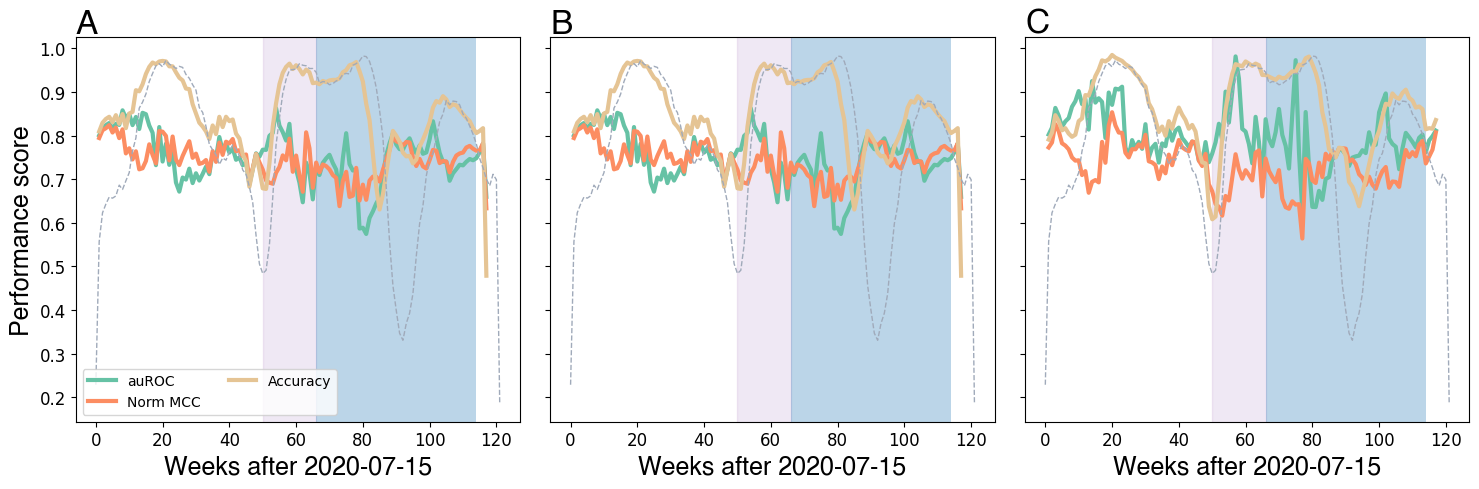

In [9]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey = 'all')

# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_period, label='auROC', linewidth = 3, color = palette[0])
axs[0].plot(weeks_to_predict, norm_MCC_by_week_naive_period, label='Norm MCC', linewidth = 3, color = palette[1])
axs[0].plot(weeks_to_predict, accuracy_by_week_naive_period, label='Accuracy', linewidth = 3, color = palette[5])
axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

# Plot data on the same plot
axs[1].plot(weeks_to_predict, ROC_by_week_naive_exact, label='auROC', linewidth = 3, color = palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_naive_exact, label='Norm MCC', linewidth = 3, color = palette[1])
axs[1].plot(weeks_to_predict, accuracy_by_week_naive_exact, label='Accuracy', linewidth = 3, color = palette[5])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

axs[2].plot(weeks_to_predict, ROC_by_week_naive_shifted, label='auROC', linewidth=3, color=palette[0])
axs[2].plot(weeks_to_predict, norm_MCC_by_week_naive_shifted, label='Norm MCC', linewidth = 3, color = palette[1])
axs[2].plot(weeks_to_predict, accuracy_by_week_naive_shifted, label='Accuracy', linewidth=3, color=palette[5])
axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

# Add labels and legend
axs[0].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[1].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[2].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

for ax in axs:
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
plt.tight_layout()

#plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_naive_expanding_train_models_period_exact_shifted_test_{size_of_test_dataset}_week.png', dpi = 300)

# Full Classifier

In [10]:
new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_training_set/Full_model_period_incl_NA'
os.chdir(new_directory)

In [11]:
clf_full_period = DecisionTreeClassifier( random_state=10, class_weight='balanced')

In [12]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

 MODEL TRAINING DONE ON CLUSTER

Get metrics from loaded models

In [13]:

# Initialize lists to store results
ROC_by_week_full_period = []
accuracy_by_week_full_period = []
norm_MCC_by_week_full_period = []

ROC_by_week_full_shifted = []
accuracy_by_week_full_shifted = []
norm_MCC_by_week_full_shifted = []

ROC_by_week_full_exact = []
accuracy_by_week_full_exact = []
norm_MCC_by_week_full_exact = []

size_of_test_dataset = 1

for prediction_week in weeks_to_predict:
    # Evaluate the period model
    #model_name = "Full_model"
    #accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'period', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    #X_train, y_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(data = HSA_weekly_data_all, 
    #        no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1),  weeks_in_future=weeks_in_future, geography='HSA_ID', weight_col=weight_col, keep_output=keep_output)
    #accuracy_by_week_full_period.append(accuracy_period)
    #ROC_by_week_full_period.append(roc_auc_period)
    #norm_MCC_by_week_full_period.append(mcc_period)

    # Evaluate the shifted model
    model_name = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_shifted_NA/Full_model"
    accuracy_shifted, roc_auc_shifted, mcc_shifted = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'shifted', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_full_shifted.append(accuracy_shifted)
    ROC_by_week_full_shifted.append(roc_auc_shifted)
    norm_MCC_by_week_full_shifted.append(mcc_shifted)

     #Evaluate the exact model
    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_exact/Full_model"
    accuracy_exact, roc_auc_exact, mcc_exact = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'exact', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_full_exact.append(accuracy_exact)
    ROC_by_week_full_exact.append(roc_auc_exact)
    norm_MCC_by_week_full_exact.append(mcc_exact)

Best and worst classifiers - period model

In [14]:
max_index = ROC_by_week_full_exact.index(max(ROC_by_week_full_exact))
best_model_week = max_index + 1 # have to add because of zero indexing
print(best_model_week)
print(ROC_by_week_full_exact[max_index])
# Find the index of the minimum value
min_index = ROC_by_week_full_exact.index(min(ROC_by_week_full_exact))
worst_model_week = min_index + 1
print(worst_model_week)
print(ROC_by_week_full_exact[min_index])

20
0.9608293813583156
117
0.7460296118972274


In [15]:
time_period = 'exact'
Best_model = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_exact/Full_model_" + time_period + "_" + str(best_model_week) + ".sav"
Worst_model = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_exact/Full_model_" + time_period + "_" + str(worst_model_week) + ".sav"


clf_full_period_best = pickle.load(open(Best_model, 'rb'))
clf_full_period_worst = pickle.load(open(Worst_model, 'rb'))

Best_model = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_exact/Full_model_best_" + time_period + ".sav"
Worst_model = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_exact/Full_model_worst_" + time_period + ".sav"
pickle.dump(clf_full_period_best, open(Best_model, 'wb'))
pickle.dump(clf_full_period_worst, open(Worst_model, 'wb'))

# Only features used in CDC classifiers - shifted period

In [16]:
HSA_only_CDC = pd.read_csv("/Users/rem76/Documents/COVID_projections/COVID_forecasting/hsa_time_data_all_dates_CDC_features_only_incl_NA.csv")

CDC A

In [163]:
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

ROC_by_week_CDC_A_period = []
accuracy_by_week_CDC_A_period = []
norm_MCC_by_week_CDC_A_period = []

ROC_by_week_CDC_A_shifted = []
accuracy_by_week_CDC_A_shifted = []
norm_MCC_by_week_CDC_A_shifted = []

ROC_by_week_CDC_A_exact = []
accuracy_by_week_CDC_A_exact = []
norm_MCC_by_week_CDC_A_exact = []

size_of_test_dataset = 1
keep_output = False

for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "/Users/rem76/Documents/COVID_projections/CDC_A/CDC_A_incl_NA/CDC_model"
    
    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'period', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_A_period.append(accuracy_period)
    ROC_by_week_CDC_A_period.append(roc_auc_period)
    norm_MCC_by_week_CDC_A_period.append(mcc_period)

    # Evaluate the shifted model
    accuracy_shifted, roc_auc_shifted, mcc_shifted = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'shifted', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_A_shifted.append(accuracy_shifted)
    ROC_by_week_CDC_A_shifted.append(roc_auc_shifted)
    norm_MCC_by_week_CDC_A_shifted.append(mcc_shifted)

    # Evaluate the exact model
    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis/CDC_A/CDC_model"

    accuracy_exact, roc_auc_exact, mcc_exact = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'exact', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_A_exact.append(accuracy_shifted)
    ROC_by_week_CDC_A_exact.append(roc_auc_shifted)
    norm_MCC_by_week_CDC_A_exact.append(mcc_shifted)

CDC B

In [164]:
ROC_by_week_CDC_B_period = []
accuracy_by_week_CDC_B_period = []
norm_MCC_by_week_CDC_B_period = []

ROC_by_week_CDC_B_shifted = []
accuracy_by_week_CDC_B_shifted = []
norm_MCC_by_week_CDC_B_shifted = []

ROC_by_week_CDC_B_exact = []
accuracy_by_week_CDC_B_exact = []
norm_MCC_by_week_CDC_B_exact = []

size_of_test_dataset = 1
keep_output = True
for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "/Users/rem76/Documents/COVID_projections/CDC_B/CDC_B_incl_NA/CDC_model"
    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'period', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_B_period.append(accuracy_period)
    ROC_by_week_CDC_B_period.append(roc_auc_period)
    norm_MCC_by_week_CDC_B_period.append(mcc_period)

    # Evaluate the shifted model
    accuracy_shifted, roc_auc_shifted, mcc_shifted = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'shifted', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_B_shifted.append(accuracy_shifted)
    ROC_by_week_CDC_B_shifted.append(roc_auc_shifted)
    norm_MCC_by_week_CDC_B_shifted.append(mcc_shifted)
    
    # Evaluate the exact model
    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis/CDC_B/CDC_model"

    accuracy_exact, roc_auc_exact, mcc_exact = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'exact', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_B_exact.append(accuracy_shifted)
    ROC_by_week_CDC_B_exact.append(roc_auc_shifted)
    norm_MCC_by_week_CDC_B_exact.append(mcc_shifted)

# Combined graph for immediate period - panel for each metric, line for each model type 

In [126]:
palette = ['#77CCB1', '#E78964', '#8da0cb', '#e5c494' , '#e5c494', '#FFED66']


ValueError: x and y must have same first dimension, but have shapes (117,) and (0,)

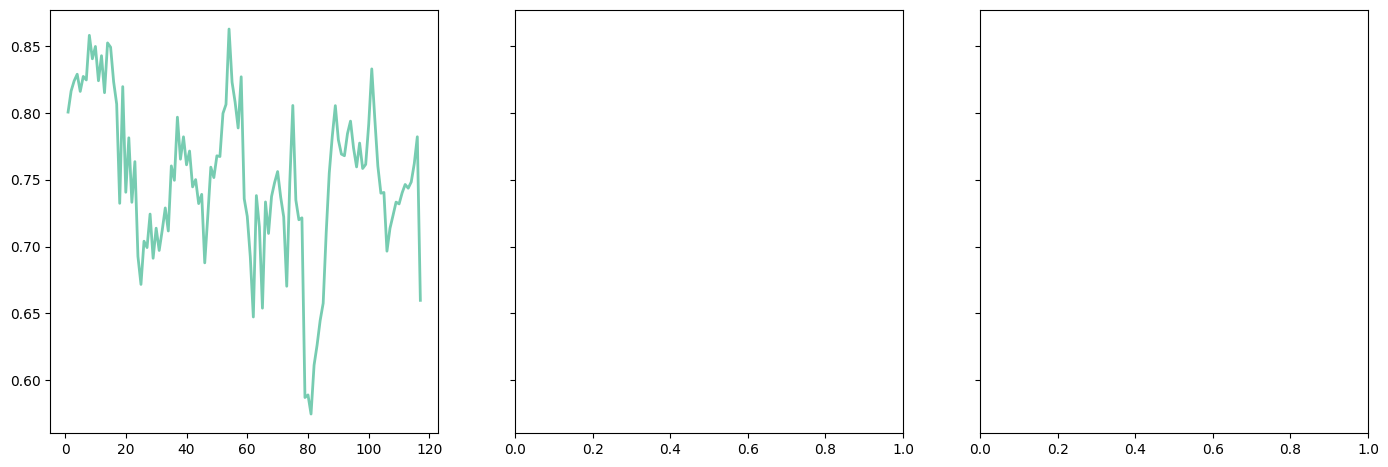

In [20]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 5.5), sharey = 'all')
axs = axs.ravel()
axs[0].plot(weeks_to_predict, ROC_by_week_naive_period, label='Naive', linewidth = 2, color = palette[0])
axs[0].plot(weeks_to_predict, ROC_by_week_full_period, label='Full', linewidth = 2, color = palette[1])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_A_period, label='CDC A', linewidth = 2, color = palette[2])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_B_period, label='CDC B', linewidth = 2, color = palette[3])

axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--', label = 'Prop. HSAs exceeding threshold')
axs[0].set_title("auROC",fontsize=20)

axs[1].plot(weeks_to_predict, norm_MCC_by_week_naive_period, label='Naive', linewidth = 2, color = palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_full_period, label='Full', linewidth = 2, color = palette[1])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_CDC_A_period, label='CDC A', linewidth = 2, color = palette[2])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_CDC_B_period, label='CDC B', linewidth = 2, color = palette[3])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')
axs[1].set_title("Normalized MCC",fontsize=20)

axs[2].plot(weeks_to_predict, accuracy_by_week_naive_period, label='Naive', linewidth = 2, color = palette[0])
axs[2].plot(weeks_to_predict, accuracy_by_week_full_period, label='Full', linewidth = 2, color = palette[1])
axs[2].plot(weeks_to_predict, accuracy_by_week_CDC_A_period, label='CDC A', linewidth = 2, color = palette[2])
axs[2].plot(weeks_to_predict, accuracy_by_week_CDC_B_period, label='CDC B', linewidth = 2, color = palette[3])
axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')
axs[2].set_title("Accuracy",fontsize=20)
# Add labels and legend

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

plt.tight_layout()
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    ax.tick_params(axis='both', which='major', labelsize=14)

    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
plt.tight_layout()
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_expanding_train_models_immediate_test_{size_of_test_dataset}_week_by_metric.png', dpi = 300)

# Data from classifiers trained only on the CDC period 

In [71]:
def determine_covid_outcome_indicator(
    new_cases_per_100k, new_admits_per_100k, percent_beds_100k
):
    if new_cases_per_100k < 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > 0.10):
            if (new_admits_per_100k >= 20) | (percent_beds_100k >= 15):
                return 'High'
            else:
                return 'Medium'
        else:
            return 'Low'
    elif new_cases_per_100k >= 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k >= 0.10):
            return 'High'
        elif (new_admits_per_100k < 10) | (percent_beds_100k < 10):
            return 'Medium'

In [51]:
from Functions import calculate_maximum_reget, add_labels_to_subplots, merge_and_rename_data, pivot_data_by_HSA, create_column_names, create_collated_weekly_data, add_changes_by_week, calculate_metrics, merge_and_rename_data, add_changes_by_week, prep_training_test_data_period, prep_training_test_data, prep_training_test_data_shifted, cross_validation_leave_geo_out, prepare_data_and_model

data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

#data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
# go a week earlier so can calculate the "delta" variables
start_date = pd.to_datetime('2022-01-10')
end_date = pd.to_datetime('2022-03-14')
data_by_HSA['date'] = pd.to_datetime(data_by_HSA['date'])
data_by_HSA_CDC_dates = data_by_HSA[(data_by_HSA['date'] >= start_date) & (data_by_HSA['date'] <= end_date)]

for i, week in enumerate(data_by_HSA_CDC_dates['date'].unique()):
    data_by_HSA_CDC_dates.loc[data_by_HSA_CDC_dates['date'] == week, 'week'] = i


## pivot
data_by_HSA_CDC_dates_cases = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_CDC_dates_admissions = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_CDC_dates_percent_beds = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_CDC_dates_over_15_100k = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge (incl outcome)
data_by_HSA_CDC_dates_cases_admits = merge_and_rename_data(data_by_HSA_CDC_dates_cases, data_by_HSA_CDC_dates_admissions,'week','cases', 'admits')

data_by_HSA_CDC_dates_admits_perc_outcome = merge_and_rename_data(data_by_HSA_CDC_dates_percent_beds, data_by_HSA_CDC_dates_over_15_100k,'week','perc_covid', 'beds_over_15_100k')
data_by_HSA_CDC_dates_cases_admits_perc_outcome= pd.merge(data_by_HSA_CDC_dates_cases_admits, data_by_HSA_CDC_dates_admits_perc_outcome, on='week')

data_by_HSA_CDC_dates_cases_admits_perc_outcome = data_by_HSA_CDC_dates_cases_admits_perc_outcome.reset_index()
data_by_HSA_CDC_dates_cases_admits_perc_outcome.columns = data_by_HSA_CDC_dates_cases_admits_perc_outcome.columns.str.replace(',', '')

## collate weekly data
categories_for_subsetting = ['cases', 'admits','perc_covid', 'beds_over_15_100k']
num_of_weeks = len(data_by_HSA_CDC_dates_cases_admits_perc_outcome)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_CDC_dates_cases_admits_perc_outcome, data_by_HSA_CDC_dates, categories_for_subsetting, 'HSA_ID', column_names)

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns={'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.


In [27]:
# go a week earlier so can calculate the "delta" variables
start_date = pd.to_datetime('2022-01-03')
end_date = pd.to_datetime('2022-03-14')
data_by_HSA_CDC_dates = data_by_HSA[(data_by_HSA['date'] >= start_date) & (data_by_HSA['date'] <= end_date)]

for i, week in enumerate(data_by_HSA_CDC_dates['date'].unique()):
    data_by_HSA_CDC_dates.loc[data_by_HSA_CDC_dates['date'] == week, 'week'] = i

data_by_HSA__cases = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA__deaths = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA__admissions = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA__icu = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA__beds = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA__percent_beds = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA__over_15_100k = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge 
data_by_HSA__cases_deaths = merge_and_rename_data(data_by_HSA__cases, data_by_HSA__deaths,'week','cases', 'deaths')
data_by_HSA__admits_icu_weekly = merge_and_rename_data(data_by_HSA__admissions, data_by_HSA__icu,'week','admits', 'icu')
data_by_HSA__beds_perc_weekly = merge_and_rename_data(data_by_HSA__beds, data_by_HSA__percent_beds,'week','beds', 'perc_covid')
data_by_HSA__cases_deaths_admits_icu = pd.merge(data_by_HSA__cases_deaths, data_by_HSA__admits_icu_weekly, on='week')
data_by_HSA__cases_deaths_admits_icu_beds = pd.merge(data_by_HSA__cases_deaths_admits_icu, data_by_HSA__beds_perc_weekly, on='week')

## add outcome variable 
old_column_names = data_by_HSA__over_15_100k.columns
new_column_names = [str(col) + '_beds_over_15_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA__over_15_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA__cases_deaths_admits_icu_beds = pd.merge(data_by_HSA__cases_deaths_admits_icu_beds, data_by_HSA__over_15_100k, on='week')

data_by_HSA__cases_deaths_admits_icu_beds = data_by_HSA__cases_deaths_admits_icu_beds.reset_index()
data_by_HSA__cases_deaths_admits_icu_beds.columns = data_by_HSA__cases_deaths_admits_icu_beds.columns.str.replace(',', '')

all_HSA_ID_weekly_data_full = add_changes_by_week(data_by_HSA__cases_deaths_admits_icu_beds, "beds_over_15_100k")

categories_for_subsetting = [ 'cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid',  'cases_delta', 'deaths_delta', 'admits_delta', 'icu_delta', 'beds_delta', 'perc_covid_delta','beds_over_15_100k']
num_of_weeks = len(data_by_HSA__cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

all_HSA_ID_weekly_data_full = create_collated_weekly_data(all_HSA_ID_weekly_data_full, data_by_HSA_CDC_dates, categories_for_subsetting, 'HSA_ID', column_names)

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data_full['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns={'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df['weight'].unique()
all_HSA_ID_weekly_data_full = all_HSA_ID_weekly_data_full.join(weights_df['weight'])

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [53]:
selected_columns = [col for col in all_HSA_ID_weekly_data.columns if 'beds_over_15_100k' in col]
naive_data = all_HSA_ID_weekly_data[selected_columns + ['HSA_ID'] + ['weight']]



In [72]:

weeks_to_predict = range(1, 6)

accuracy_by_week_naive = []
ROC_by_week_naive = []
norm_MCC_by_week_naive = []

accuracy_by_week_CDC_A = []
ROC_by_week_CDC_A = []
norm_MCC_by_week_CDC_A = []

accuracy_by_week_CDC_B = []
ROC_by_week_CDC_B = []
norm_MCC_by_week_CDC_B = []

accuracy_by_week_full = []
ROC_by_week_full = []
norm_MCC_by_week_full = []

accuracy_by_week_CL = []
ROC_by_week_CL = []
norm_MCC_by_week_CL = []

for week in weeks_to_predict: 
    # naive classifier 
    naive_classifier = pickle.load(open('/Users/rem76/Documents/COVID_projections/COVID_forecasting/CDC_classifier_auroc_0.7234_CDC_period_naive.sav', 'rb'))
    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(naive_data,   no_weeks = range(week, week + 1), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
    y_pred_Classifier_naive = naive_classifier.predict(X_test)
    y_pred_proba_Classifier_naive = naive_classifier.predict_proba(X_test)
    accuracy_naive = accuracy_score(y_test, y_pred_Classifier_naive)
    ROC_naive = roc_auc_score(y_test[0], y_pred_proba_Classifier_naive[:,1])
    MCC_naive = (matthews_corrcoef(y_test, y_pred_Classifier_naive) + 1)/2
    accuracy_by_week_naive.append(accuracy_naive)
    ROC_by_week_naive.append(ROC_naive)
    norm_MCC_by_week_naive.append(MCC_naive)

    # cdc A
    CDC_Classifier_A = pickle.load(open('/Users/rem76/Documents/COVID_projections/COVID_forecasting/CDC_classifier_auroc_0.8155_CDC_period.sav', 'rb'))
    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(week, week + 1), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
    y_pred_Classifier_A = CDC_Classifier_A.predict(X_test)
    y_pred_proba_Classifier_A = CDC_Classifier_A.predict_proba(X_test)
    accuracy_CDC_A = accuracy_score(y_test, y_pred_Classifier_A)
    ROC_CDC_A  = roc_auc_score(y_test[0], y_pred_proba_Classifier_A[:,1])
    MCC_CDC_A  = (matthews_corrcoef(y_test, y_pred_Classifier_A) + 1)/2
    accuracy_by_week_CDC_A.append(accuracy_CDC_A)
    ROC_by_week_CDC_A.append(ROC_CDC_A)
    norm_MCC_by_week_CDC_A.append(MCC_CDC_A)



    CDC_Classifier_B = pickle.load(open('/Users/rem76/Documents/COVID_projections/COVID_forecasting/CDC_classifier_auroc_0.8234_CDC_period_B.sav', 'rb'))
    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(week, week + 1), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
    y_pred = CDC_Classifier_B.predict(X_test)
    y_pred_proba_Classifier_B = CDC_Classifier_B.predict_proba(X_test)

    # Evaluate the accuracy of the model
    accuracy_CDC_B = accuracy_score(y_test, y_pred)
    ROC_CDC_B = roc_auc_score(y_test[0], y_pred_proba_Classifier_B[:,1])
    MCC_CDC_B = (matthews_corrcoef(y_test, y_pred) + 1)/2
    accuracy_by_week_CDC_B.append(accuracy_CDC_B)
    ROC_by_week_CDC_B.append(ROC_CDC_B)
    norm_MCC_by_week_CDC_B.append(MCC_CDC_B)

    # full model 
    full_model = pickle.load(open('/Users/rem76/Documents/COVID_projections/COVID_forecasting/CDC_classifier_auroc_0.8872_CDC_period_full.sav', 'rb'))
    model_name = '/Users/rem76/Documents/COVID_projections/COVID_forecasting/CDC_classifier_auroc_0.8872_CDC_period_full.sav'
    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data_full,   no_weeks = range(week + 1, week +2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True) # account for the fact that week 1 is the week included to allow for calculation of delta
    y_pred = full_model.predict(X_test)
    y_pred_proba_full = full_model.predict_proba(X_test)
    accuracy_full = accuracy_score(y_test, y_pred)
    ROC_full = roc_auc_score(y_test[0], y_pred_proba_full[:,1])
    MCC_full = (matthews_corrcoef(y_test, y_pred) + 1)/2 
    accuracy_by_week_full.append(accuracy_full)
    ROC_by_week_full.append(ROC_full)
    norm_MCC_by_week_full.append(MCC_full)


    # CDC model 
    CDC_predictions_levels = pd.DataFrame(index=data_by_HSA_CDC_dates_cases_admits_perc_outcome['week'])
    indicators, actual_outcome, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,  no_weeks = range(week, week +1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = False)
    weights = weights[0].to_numpy()
    for idx, row in indicators.iterrows():
        outcome = determine_covid_outcome_indicator(row[1], row[2], row[3])
        CDC_predictions_levels.at[idx, 0] = outcome

    replacement_map = {'Low': 0, 'Medium': 0, 'High': 1}

    # Replace values in the 'CDC_predictions_levels' column
    CDC_predictions_levels_binary = CDC_predictions_levels[0].replace(replacement_map)
    # Calculate the percentage of cases where the predicted CDC risk level is 'High' and actual outcome is 1
    sum_high_and_1 = np.sum((CDC_predictions_levels == 'High') & (actual_outcome == 1))
    sum_high_and_0 = np.sum((CDC_predictions_levels == 'High') & (actual_outcome == 0))
    total_high_predictions = np.sum(CDC_predictions_levels == 'High')
    percentage_high_and_1 = (sum_high_and_1 / total_high_predictions) * 100
    print("Percentage High and 1: {:.2f}%".format(float(percentage_high_and_1)))

    # Calculate the percentage of cases where the predicted CDC risk level is 'Medium' and actual outcome is 1
    sum_med_and_1 = np.sum((CDC_predictions_levels == 'Medium') & (actual_outcome == 1))
    sum_med_and_0 = np.sum((CDC_predictions_levels == 'Medium') & (actual_outcome == 0))

    total_med_predictions = np.sum(CDC_predictions_levels == 'Medium')
    percentage_med_and_1 = (sum_med_and_1 / total_med_predictions) * 100
    print("Percentage Medium and 1: {:.2f}%".format(float(percentage_med_and_1)))

    # Calculate the percentage of cases where the predicted CDC risk level is 'Low' and actual outcome is 1
    sum_low_and_1 = np.sum((CDC_predictions_levels == 'Low') & (actual_outcome == 1))
    sum_low_and_0 = np.sum((CDC_predictions_levels == 'Low') & (actual_outcome == 0))
    total_low_predictions = np.sum(CDC_predictions_levels == 'Low')
    percentage_low_and_1 = (sum_low_and_1 / total_low_predictions) * 100
    print("Percentage Low and 1: {:.2f}%".format(float(percentage_low_and_1)))
    # Calculate the True Positive Rate (Sensitivity) and False Positive Rate for different levels
    tpr_high = sum_high_and_1 / total_high_predictions
    fpr_high = (total_high_predictions - sum_high_and_1) / total_high_predictions

    tpr_med = (total_med_predictions - sum_med_and_1) / total_med_predictions
    fpr_med = sum_med_and_1 / total_med_predictions

    tpr_low = (total_low_predictions - sum_low_and_1) / total_low_predictions
    fpr_low = sum_low_and_1 / total_low_predictions

    # Create ROC curve points
    roc_points = [(fpr_low, tpr_low), (fpr_med, tpr_med), (fpr_high, tpr_high)]

    # Calculate AUROC score
    auroc_score_CL = roc_auc_score(actual_outcome, CDC_predictions_levels_binary)
    accuracy_Community_levels = accuracy_score(actual_outcome, CDC_predictions_levels_binary)
    MCC_Community_levels = (matthews_corrcoef(actual_outcome, CDC_predictions_levels_binary) + 1)/2

    accuracy_by_week_CL.append(accuracy_Community_levels)
    ROC_by_week_CL.append(auroc_score_CL)
    norm_MCC_by_week_CL.append(MCC_Community_levels)


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use flo

Percentage High and 1: 99.08%
Percentage Medium and 1: 79.49%
Percentage Low and 1: 100.00%
Percentage High and 1: 98.07%
Percentage Medium and 1: 66.67%
Percentage Low and 1: nan%
Percentage High and 1: 95.52%
Percentage Medium and 1: 57.14%
Percentage Low and 1: nan%
Percentage High and 1: 92.57%
Percentage Medium and 1: 36.36%
Percentage Low and 1: nan%
Percentage High and 1: 89.02%
Percentage Medium and 1: 52.38%
Percentage Low and 1: 0.00%


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


# Combined graph for exact period - panel for each metric, line for each model type 

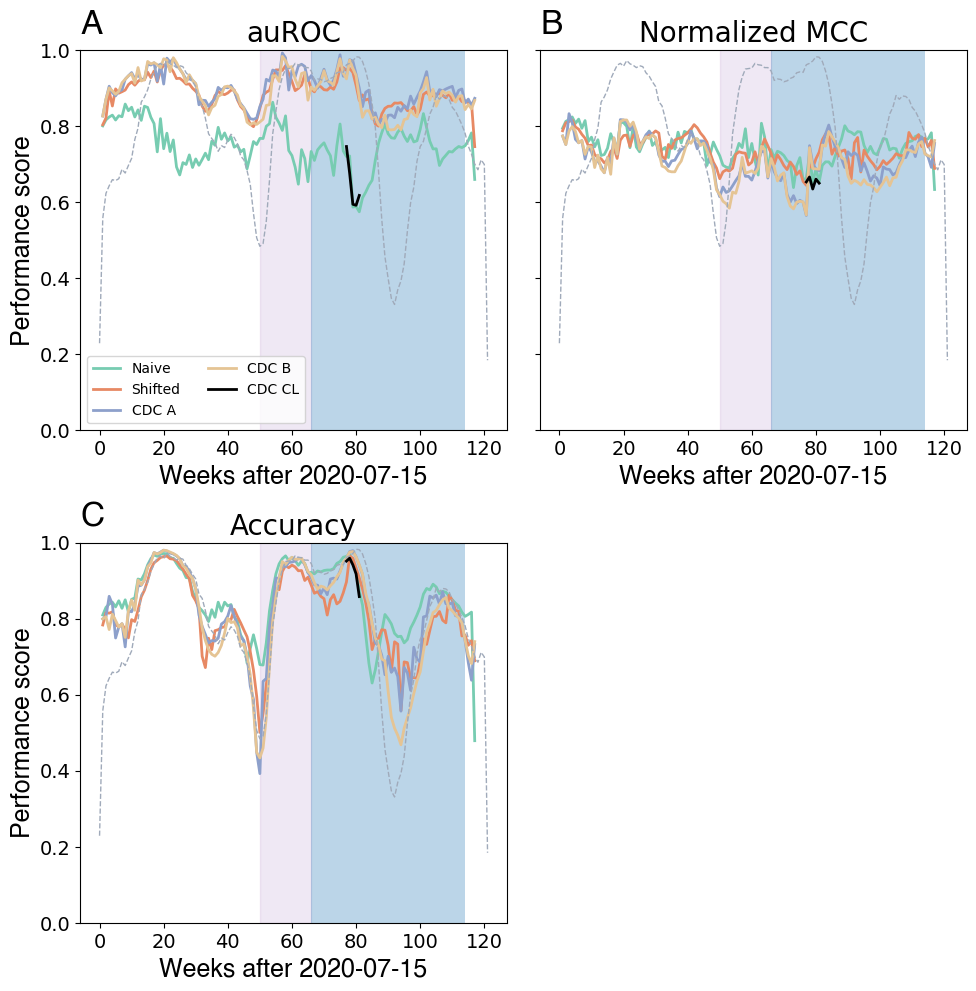

In [127]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey = 'all')
axs = axs.ravel()
fig.delaxes(axs[3])
weeks_to_predict = range(1, 118)
# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_exact, label='Naive', linewidth=2, color=palette[0])
axs[0].plot(weeks_to_predict, ROC_by_week_full_exact, label='Shifted', linewidth=2, color=palette[1])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_A_exact, label='CDC A', linewidth=2, color=palette[2])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_B_exact, label='CDC B', linewidth=2, color=palette[3])
axs[0].plot(range(77, 82), ROC_by_week_CL, label='CDC CL', linewidth=2, color='black')


axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')#, label='Prop. HSAs exceeding threshold')
axs[0].set_title("auROC", fontsize=20)

axs[1].plot(weeks_to_predict, norm_MCC_by_week_naive_exact, label='Naive', linewidth=2, color=palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_full_exact, label='Full', linewidth=2, color=palette[1])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_CDC_A_exact, label='CDC A', linewidth=2, color=palette[2])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_CDC_B_exact, label='CDC B', linewidth=2, color=palette[3])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')
axs[1].plot(range(77, 82), norm_MCC_by_week_CL, label='CDC CL', linewidth=2, color='black')

axs[1].set_title("Normalized MCC", fontsize=20)

axs[2].plot(weeks_to_predict, accuracy_by_week_naive_exact, label='Naive', linewidth=2, color=palette[0])
axs[2].plot(weeks_to_predict, accuracy_by_week_full_exact, label='Full', linewidth=2, color=palette[1])
axs[2].plot(weeks_to_predict, accuracy_by_week_CDC_A_exact, label='CDC A', linewidth=2, color=palette[2])
axs[2].plot(weeks_to_predict, accuracy_by_week_CDC_B_exact, label='CDC B', linewidth=2, color=palette[3])
axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')
axs[2].plot(range(77, 82), accuracy_by_week_CL, label='CDC CL', linewidth=2, color='black')

axs[2].set_title("Accuracy", fontsize=20)

# Add labels and legend

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[2].set_ylabel('Performance score',**hfont,  fontsize = 18)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')
axs[0].set_ylim(0,1)

for ax in axs:
    ax.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    ax.tick_params(axis='both', which='major', labelsize=14)

    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
plt.tight_layout()
#plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_expanding_train_models_exact_test_{size_of_test_dataset}_week_by_metric.png', dpi = 300)

# Combined graph of just auROC and the MR

In [143]:
# Load the dictionary from the file
with open('/Users/rem76/Documents/COVID_projections/maximum_regret_by_model_ROC.json', 'r') as json_file:
    maximum_regret_by_model_ROC = json.load(json_file)

In [141]:
def calculate_maximum_reget(
    metric, metrics_by_model, models, time_period, weeks_to_predict
):
    metric_data = metrics_by_model[metric]

    maximum_regret_by_model = {model: [] for model in models}
    for j, prediction_week in enumerate(weeks_to_predict):
        print(prediction_week)
        best_metric = float("-inf")

        for i, m in enumerate(metric_data):
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]
            if model_metric >= best_metric:
                best_metric = model_metric

        for i, m in enumerate(metric_data):
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]
            model = models[i]
            if model_metric >= best_metric:
                maximum_regret_by_model[model].append(0)
            else:
                maximum_regret_by_model[model].append(best_metric - model_metric)

    return maximum_regret_by_model

In [204]:
ROC_by_week_CL_mod = 76*[0] + ROC_by_week_CL + (117 - 81)*[0]

In [205]:
all_models_auROC = {
    "ROC_by_week_CDC_B_exact": ROC_by_week_CDC_B_exact,
    "ROC_by_week_CDC_A_exact": ROC_by_week_CDC_A_exact,
    "ROC_by_week_Full_exact": ROC_by_week_full_exact,
    "ROC_by_week_Naive_exact": ROC_by_week_naive_exact,
    "ROC_by_week_CL_mod": ROC_by_week_CL_mod
}

In [206]:
models = ['Naive', 'Full', 'CDC A', 'CDC B', 'CDC CL']
all_metrics = {}
all_metrics['ROC'] = all_models_auROC
weeks_to_predict = range(1, 117)

In [207]:
maximum_regret_by_model_ROC =calculate_maximum_reget('ROC', all_metrics, models, time_period, weeks_to_predict)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


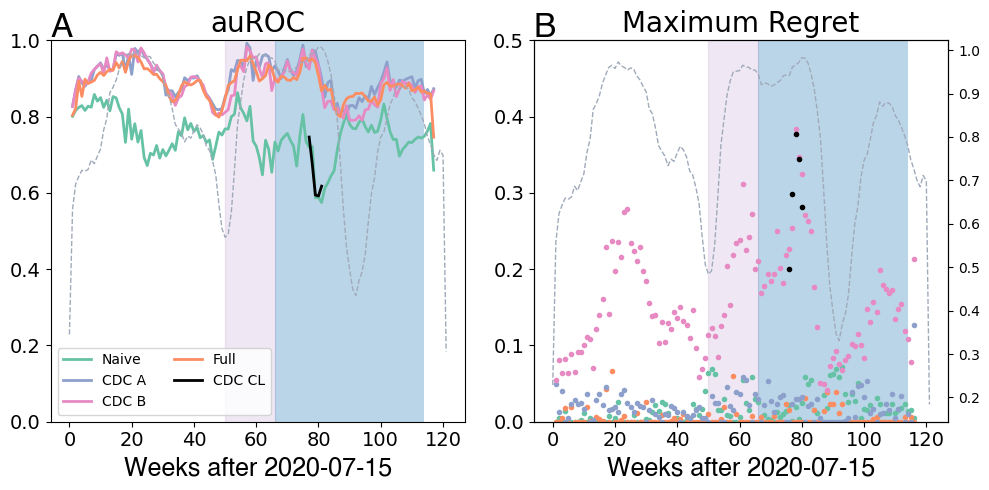

In [218]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols = 2, figsize=(10, 5), sharex = 'all')
axs = axs.ravel()
weeks_to_predict = range(1, 118)
# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_exact, label='Naive', linewidth=2, color=palette[0])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_A_exact, label='CDC A', linewidth=2, color=palette[2])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_B_exact, label='CDC B', linewidth=2, color=palette[3])
axs[0].plot(weeks_to_predict, ROC_by_week_full_exact, label='Full', linewidth=2, color=palette[1])
axs[0].plot(range(77, 82), ROC_by_week_CL, label='CDC CL', linewidth=2, color='black')

axs[0].set_title("auROC", fontsize=20)

axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')#, label='Prop. HSAs exceeding threshold')

weeks_to_predict = range(1, 117)
second_axs = axs[1].twinx()

for i, model in enumerate(models):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
    axs[1].plot(weeks_to_predict, maximum_regret_by_model_ROC[model], label=model, marker = '.', linestyle = '', color = colour)
second_axs.plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')
axs[1].set_title("Maximum Regret", fontsize=20)


axs[0].legend(ncol = 2, loc='lower left')
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,.5)
add_labels_to_subplots(axs, hfont, 1.01, 24)
for ax in axs:
    ax.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    ax.tick_params(axis='both', which='major', labelsize=14)

    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
plt.tight_layout()

plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_MR_expanding_train_models_exact_test_{size_of_test_dataset}_week_by_metric.png', dpi = 300)


# No case or death data (which is now unavailable anyway)

In [ ]:
os.chdir('/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_no_cases_no_deaths')

In [ ]:
HSA_weekly_data_removed = pd.read_csv('hsa_time_data_weekly_no_cases_deaths_incl_NA.csv')

In [125]:
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


In [ ]:
columns_to_remove = [col for col in HSA_weekly_data_all.columns if 'cases' in col]
HSA_weekly_data_removed = HSA_weekly_data_all.drop(columns=columns_to_remove)

columns_to_remove = [col for col in HSA_weekly_data_all.columns if 'deaths' in col]
HSA_weekly_data_removed = HSA_weekly_data_removed.drop(columns=columns_to_remove)

In [ ]:
time_period = 'exact'

In [ ]:
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Initialize lists to store results
ROC_by_week_full_exact_removed = []
accuracy_by_week_full_exact_removed  = []
norm_MCC_by_week_full_exact_removed  = []

size_of_test_dataset = 1

for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "Full_model"
    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_removed, weeks_in_future, geography_column, weight_col, keep_output,time_period, model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_full_exact_removed .append(accuracy_period)
    ROC_by_week_full_exact_removed .append(roc_auc_period)
    norm_MCC_by_week_full_exact_removed .append(mcc_period)


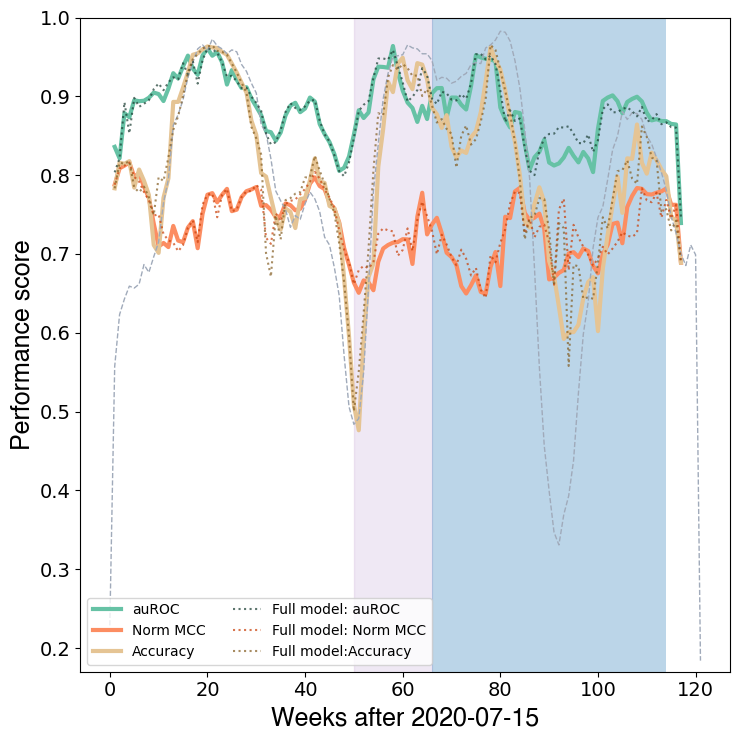

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5), sharey = 'all')

# Plot data on the same plot
axs.plot(weeks_to_predict, ROC_by_week_full_exact_removed, label='auROC', linewidth = 3, color = palette[0])
axs.plot(weeks_to_predict, norm_MCC_by_week_full_exact_removed, label='Norm MCC', linewidth = 3, color = palette[1])
axs.plot(weeks_to_predict, accuracy_by_week_full_exact_removed, label='Accuracy', linewidth = 3, color = palette[5])
axs.plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

axs.plot(weeks_to_predict, ROC_by_week_full_exact, label='Full model: auROC', linewidth = 1.5, color = '#173A2F', linestyle = ':', alpha = 0.7)
axs.plot(weeks_to_predict, norm_MCC_by_week_full_exact, label='Full model: Norm MCC', linewidth = 1.5, color = '#C83C04', linestyle = ':', alpha = 0.7)
axs.plot(weeks_to_predict, accuracy_by_week_full_exact, label='Full model:Accuracy', linewidth = 1.5, color = '#835C20', linestyle = ':', alpha = 0.7)

# Add labels and legend
axs.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

axs.set_ylabel('Performance score',**hfont,  fontsize = 18)
axs.tick_params(axis='both', which='major', labelsize=14)

axs.set_ylim(0.17,1)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs.legend(ncol = 2, loc='lower left')

polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
axs.add_patch(polygon_delta)
polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
axs.add_patch(polygon_omricon)

plt.tight_layout()
axs.legend(ncol = 2, loc='lower left')

plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_model_no_cases_deaths_exact_{size_of_test_dataset}_week.png', dpi = 300)

Changes in important features 

In [ ]:
feature_names=[ 'COVID-19  admissions', '\u0394 COVID-19 admissions', 'COVID-19 ICU beds', '\u0394 COVID-19 ICU beds',  'COVID-19 hospital beds', '\u0394 COVID-19 hospital beds', 'Perc. of beds with \nCOVID-19 patients', '\u0394 Perc. beds with \nCOVID-19 patients', '> 15 per 100,000 COVID-19 \npatients in hospital beds']
num_features = len(feature_names)
time_period = 'exact'
# Initialize a dictionary to store feature importance counts
feature_importance_counts = {feature_name: 0 for feature_name in feature_names}

# Loop through iterations
for prediction_week in weeks_to_predict:
    # Create the training data
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_shifted(HSA_weekly_data_removed, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    weights_full_period = weights_full_period[0].to_numpy()
    
    # Load and train the model 

    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_no_cases_no_deaths/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

    clf_full_period = pickle.load(open(model_name, 'rb'))
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Get feature importances for this iteration
    feature_importances = clf_full_period.feature_importances_
    
    # Update the counts for each feature
    for feature_idx, importance in enumerate(feature_importances):
        if importance > 0:
            feature_name = feature_names[feature_idx]
            feature_importance_counts[feature_name] += 1

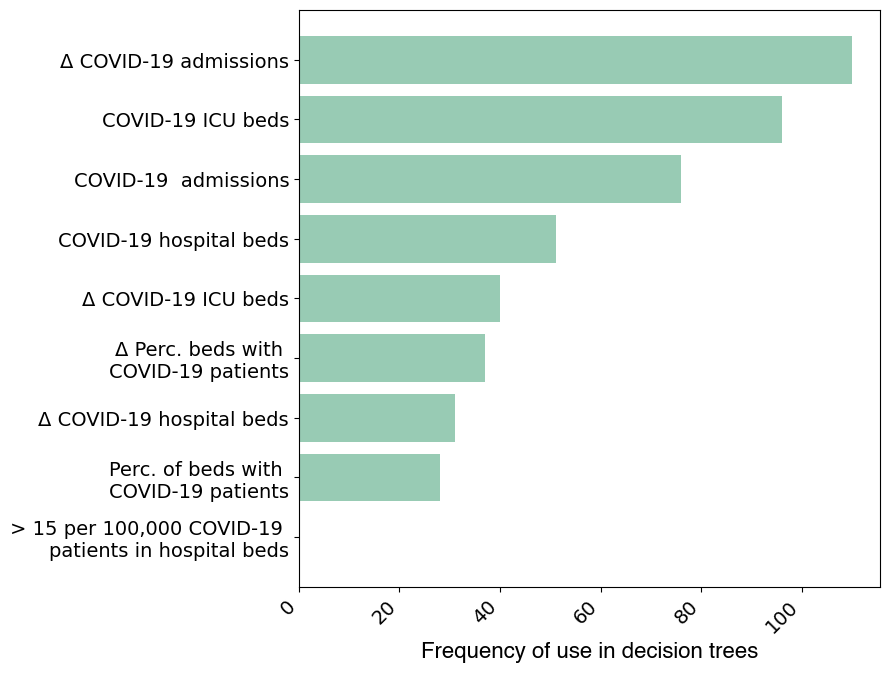

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

sorted_feature_importance_counts = dict(sorted(feature_importance_counts.items(), key=lambda item: item[1], reverse=False))

# Convert dict_keys to list
keys_list = list(sorted_feature_importance_counts.keys())

plt.barh(keys_list, sorted_feature_importance_counts.values(), color='#98CBB4')
plt.xlabel('Frequency of use in decision trees', fontsize = 16, **hfont)
plt.xticks(rotation=45, ha='right', fontsize = 14)
plt.yticks(fontsize=14) 
plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Important_features_model_no_cases_deaths_exact_{size_of_test_dataset}_week.png', dpi = 300,  bbox_inches="tight")

Shap values

In [ ]:
from scipy.special import softmax
import shap
shap_values_list = []

mean_shapley_values = []

size_of_test_dataset = 1
weeks_to_predict = range(1,117)
for prediction_week in weeks_to_predict:
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_no_cases_no_deaths/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(prediction_week)

    #period    

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_removed, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_removed, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)
        # Compute Shapley values for the current prediction
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    # Calculate the mean Shapley value importance

    mean_shapley_value = np.mean(shap_values[1], axis=0)
    mean_shapley_values.append(mean_shapley_value)
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


Prediction Week: 1
Prediction Week: 2
Prediction Week: 3
Prediction Week: 4
Prediction Week: 5
Prediction Week: 6
Prediction Week: 7
Prediction Week: 8
Prediction Week: 9
Prediction Week: 10
Prediction Week: 11
Prediction Week: 12
Prediction Week: 13
Prediction Week: 14
Prediction Week: 15
Prediction Week: 16
Prediction Week: 17
Prediction Week: 18
Prediction Week: 19
Prediction Week: 20
Prediction Week: 21
Prediction Week: 22
Prediction Week: 23
Prediction Week: 24
Prediction Week: 25
Prediction Week: 26
Prediction Week: 27
Prediction Week: 28
Prediction Week: 29
Prediction Week: 30
Prediction Week: 31
Prediction Week: 32
Prediction Week: 33
Prediction Week: 34
Prediction Week: 35
Prediction Week: 36
Prediction Week: 37
Prediction Week: 38
Prediction Week: 39
Prediction Week: 40
Prediction Week: 41
Prediction Week: 42
Prediction Week: 43
Prediction Week: 44
Prediction Week: 45
Prediction Week: 46
Prediction Week: 47
Prediction Week: 48
Prediction Week: 49
Prediction Week: 50
Predictio

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


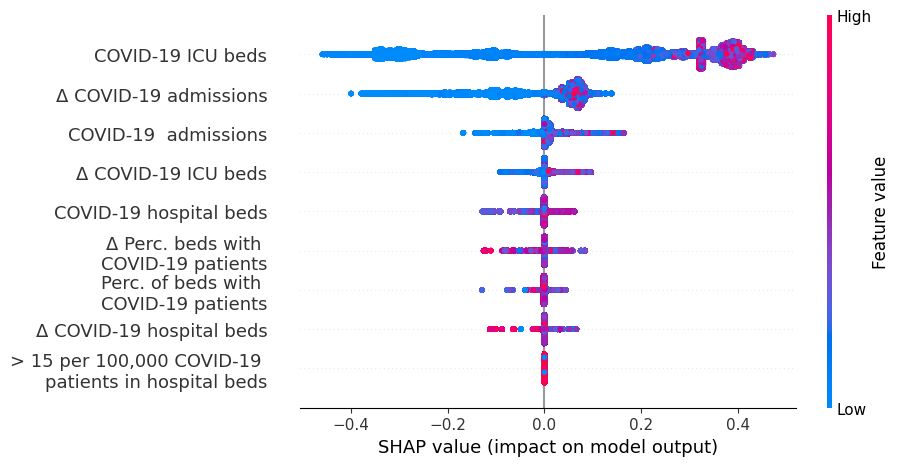

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

# Initialize empty lists to store mean Shapley values and prediction weeks
mean_shapley_values = []
prediction_weeks = []

size_of_test_dataset = 1

for prediction_week in weeks_to_predict:
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_no_cases_no_deaths/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(f"Prediction Week: {prediction_week}")
    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_removed, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_removed, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    # Fit the model
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    X_test_full.columns = feature_names

    explainer = shap.TreeExplainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    #shap.summary_plot(shap_values, features = X_test_full.columns)
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer(X_test_full)
    # Concatenate all values
    if prediction_week == weeks_to_predict[0]:
        shap_values_all = shap_values
    else:
        for feature in X_test_full.columns: 
                shap_values_all.values = np.concatenate([shap_values_all.values, shap_values.values])
                shap_values_all.base_values = np.concatenate([shap_values_all.base_values, shap_values.base_values])
                shap_values_all.data = np.concatenate([shap_values_all.data, shap_values.data])

plt.tick_params(axis='both', which='major', labelsize=10)    #shap.summary_plot(shap_values, X_test_full, plot_type="bar", feature_names= feature_names)

shap.plots.beeswarm(shap_values_all[:,:,1], max_display=14, show=False)
plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Shap_values_model_no_cases_deaths_exact_{size_of_test_dataset}_week.png', dpi = 300)

# Now only "unimportant" features (HSA|beds_over_15_100k|weight|perc_covid|beds_delta|beds|icu)


In [98]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight|perc_covid|icu").columns.tolist()
HSA_weekly_data_unimportant = HSA_weekly_data_all[columns_to_select]

In [104]:
def prepare_data_and_model(
    data,
    weeks_in_future,
    geography,
    weight_col,
    keep_output,
    time_period,
    model_name,
    prediction_week,
    size_of_test_dataset,
    train_weeks_for_initial_model,
):
    model_name_to_load = model_name + f"_{time_period}_{prediction_week}no_hospital_beds.sav"
    clf_full = pickle.load(open(model_name_to_load, "rb"))
    if time_period == "period":
        (
            X_train,
            y_train,
            weights_train,
            missing_data_train_HSA,
        ) = prep_training_test_data_period(
            data=data,
            no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1),
            weeks_in_future=weeks_in_future,
            geography=geography,
            weight_col=weight_col,
            keep_output=keep_output,
        )

        (
            X_test,
            y_test,
            weights_test,
            missing_data_test_HSA,
        ) = prep_training_test_data_period(
            data=data,
            no_weeks=range(
                int(prediction_week + train_weeks_for_initial_model) + 1,
                int(
                    prediction_week
                    + train_weeks_for_initial_model
                    + size_of_test_dataset
                )
                + 1,
            ),
            weeks_in_future=weeks_in_future,
            geography=geography,
            weight_col=weight_col,
            keep_output=keep_output,
        )
    elif time_period == "exact":
        (
            X_train,
            y_train,
            weights_train,
            missing_data_train_HSA,
        ) = prep_training_test_data(
            data=data,
            no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1),
            weeks_in_future=weeks_in_future,
            geography=geography,
            weight_col=weight_col,
            keep_output=keep_output,
        )

        (
            X_test,
            y_test,
            weights_test,
            missing_data_test_HSA,
        ) = prep_training_test_data(
            data=data,
            no_weeks=range(
                int(prediction_week + train_weeks_for_initial_model),
                int(
                    prediction_week
                    + train_weeks_for_initial_model
                    + size_of_test_dataset
                )
                + 1,
            ),
            weeks_in_future=weeks_in_future,
            geography=geography,
            weight_col=weight_col,
            keep_output=keep_output,
        )

    elif time_period == "shifted":
        (
            X_train,
            y_train,
            weights_train,
            missing_data_train_HSA,
        ) = prep_training_test_data_shifted(
            data=data,
            no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1),
            weeks_in_future=weeks_in_future,
            geography=geography,
            weight_col=weight_col,
            keep_output=keep_output,
        )

        (
            X_test,
            y_test,
            weights_test,
            missing_data_test_HSA,
        ) = prep_training_test_data_shifted(
            data=data,
            no_weeks=range(
                int(prediction_week + train_weeks_for_initial_model) + 1,
                int(
                    prediction_week
                    + train_weeks_for_initial_model
                    + size_of_test_dataset
                )
                + 1,
            ),
            weeks_in_future=weeks_in_future,
            geography=geography,
            weight_col=weight_col,
            keep_output=keep_output,
        )

    weights_train = weights_train[0].to_numpy()
    clf_full.fit(X_train, y_train, sample_weight=weights_train)

    y_pred = clf_full.predict(X_test)
    y_pred_proba = clf_full.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    mcc = (matthews_corrcoef(y_test, y_pred) + 1) / 2

    return accuracy, roc_auc, mcc

In [105]:
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Initialize lists to store results
ROC_by_week_full_exact_unimportant = []
accuracy_by_week_full_exact_unimportant  = []
norm_MCC_by_week_full_exact_unimportant  = []

size_of_test_dataset = 1

for prediction_week in weeks_to_predict:
    # Evaluate the model
    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Only_unimportant_features/Full_model"

    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_unimportant, weeks_in_future, geography_column, weight_col, keep_output,time_period, model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_full_exact_unimportant.append(accuracy_period)
    ROC_by_week_full_exact_unimportant.append(roc_auc_period)
    norm_MCC_by_week_full_exact_unimportant.append(mcc_period)

In [106]:
feature_names=['COVID-19 ICU beds', '\u0394 COVID-19 ICU beds', 'Perc. of beds with \nCOVID-19 patients', '\u0394 Perc. beds with \nCOVID-19 patients', '> 15 per 100,000 COVID-19 \npatients in hospital beds']
num_features = len(feature_names)
time_period = 'exact'
# Initialize a dictionary to store feature importance counts
feature_importance_counts = {feature_name: 0 for feature_name in feature_names}

# Loop through iterations
for prediction_week in weeks_to_predict:
    # Create the training data
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_shifted(HSA_weekly_data_unimportant, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    weights_full_period = weights_full_period[0].to_numpy()
    
    # Load and train the model 

    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Only_unimportant_features/Full_model_" + time_period + "_" + str(prediction_week) + "no_hospital_beds.sav"

    clf_full_period = pickle.load(open(model_name, 'rb'))
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Get feature importances for this iteration
    feature_importances = clf_full_period.feature_importances_
    
    # Update the counts for each feature
    for feature_idx, importance in enumerate(feature_importances):
        if importance > 0:
            feature_name = feature_names[feature_idx]
            feature_importance_counts[feature_name] += 1

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Perc. of beds with \nCOVID-19 patients'),
  Text(0, 1, '> 15 per 100,000 COVID-19 \npatients in hospital beds'),
  Text(0, 2, 'Δ Perc. beds with \nCOVID-19 patients'),
  Text(0, 3, 'Δ COVID-19 ICU beds'),
  Text(0, 4, 'COVID-19 ICU beds')])

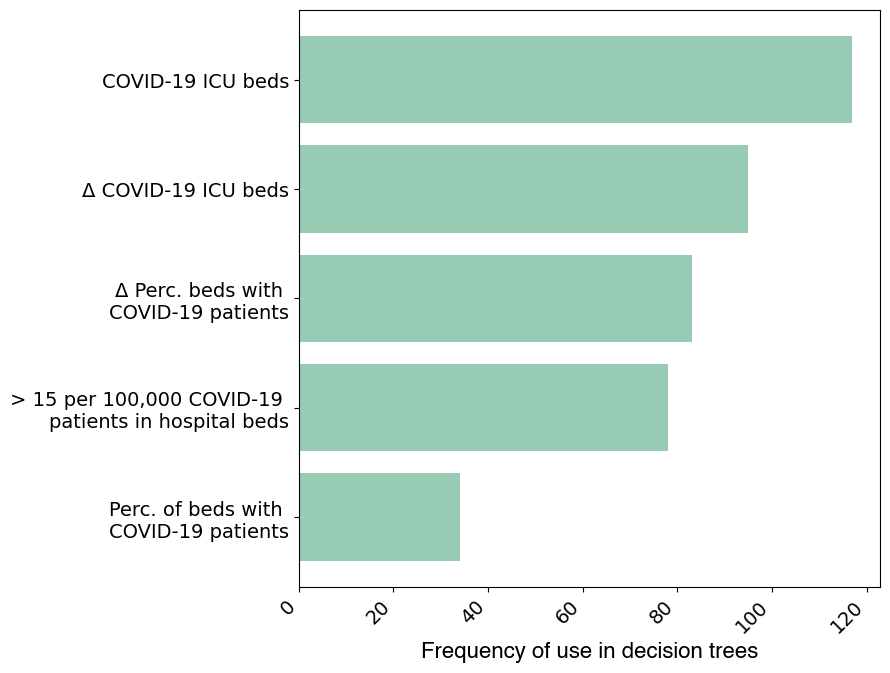

In [107]:
fig, axs = plt.subplots(1,1, figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

sorted_feature_importance_counts = dict(sorted(feature_importance_counts.items(), key=lambda item: item[1], reverse=False))

# Convert dict_keys to list
keys_list = list(sorted_feature_importance_counts.keys())

plt.barh(keys_list, sorted_feature_importance_counts.values(), color='#98CBB4')
plt.xlabel('Frequency of use in decision trees', fontsize = 16, **hfont)
plt.xticks(rotation=45, ha='right', fontsize = 14)
plt.yticks(fontsize=14) 

In [121]:
78/117

0.6666666666666666

In [116]:
from scipy.special import softmax
import shap
shap_values_list = []

mean_shapley_values = []

size_of_test_dataset = 1
weeks_to_predict = range(1,118)
for prediction_week in weeks_to_predict:
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Only_unimportant_features/Full_model_" + time_period + "_" + str(prediction_week) + "no_hospital_beds.sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(prediction_week)

    #period    

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_unimportant, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_unimportant, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)
        # Compute Shapley values for the current prediction
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    # Calculate the mean Shapley value importance

    mean_shapley_value = np.mean(shap_values[1], axis=0)
    mean_shapley_values.append(mean_shapley_value)
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


Prediction Week: 1
Prediction Week: 2
Prediction Week: 3
Prediction Week: 4
Prediction Week: 5
Prediction Week: 6
Prediction Week: 7
Prediction Week: 8
Prediction Week: 9
Prediction Week: 10
Prediction Week: 11
Prediction Week: 12
Prediction Week: 13
Prediction Week: 14
Prediction Week: 15
Prediction Week: 16
Prediction Week: 17
Prediction Week: 18
Prediction Week: 19
Prediction Week: 20
Prediction Week: 21
Prediction Week: 22
Prediction Week: 23
Prediction Week: 24
Prediction Week: 25
Prediction Week: 26
Prediction Week: 27
Prediction Week: 28
Prediction Week: 29
Prediction Week: 30
Prediction Week: 31
Prediction Week: 32
Prediction Week: 33
Prediction Week: 34
Prediction Week: 35
Prediction Week: 36
Prediction Week: 37
Prediction Week: 38
Prediction Week: 39
Prediction Week: 40
Prediction Week: 41
Prediction Week: 42
Prediction Week: 43
Prediction Week: 44
Prediction Week: 45
Prediction Week: 46
Prediction Week: 47
Prediction Week: 48
Prediction Week: 49
Prediction Week: 50
Predictio

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


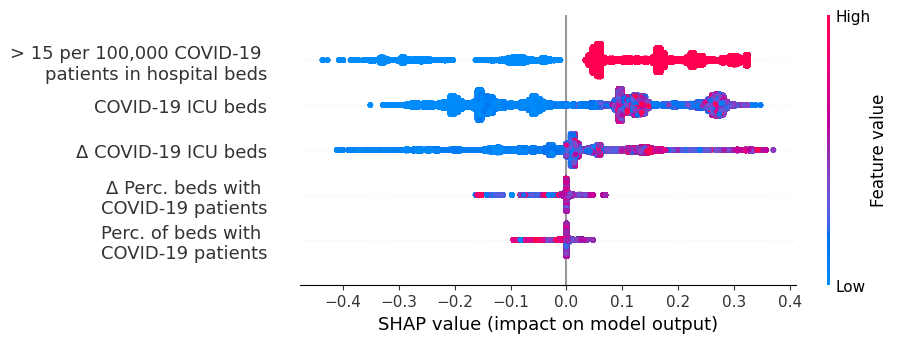

In [117]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

# Initialize empty lists to store mean Shapley values and prediction weeks
mean_shapley_values = []
prediction_weeks = []

size_of_test_dataset = 1

for prediction_week in weeks_to_predict:
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Only_unimportant_features/Full_model_" + time_period + "_" + str(prediction_week) + "no_hospital_beds.sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(f"Prediction Week: {prediction_week}")
    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_unimportant, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_unimportant, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    # Fit the model
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    X_test_full.columns = feature_names

    explainer = shap.TreeExplainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    #shap.summary_plot(shap_values, features = X_test_full.columns)
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer(X_test_full)
    # Concatenate all values
    if prediction_week == weeks_to_predict[0]:
        shap_values_all = shap_values
    else:
        for feature in X_test_full.columns: 
                shap_values_all.values = np.concatenate([shap_values_all.values, shap_values.values])
                shap_values_all.base_values = np.concatenate([shap_values_all.base_values, shap_values.base_values])
                shap_values_all.data = np.concatenate([shap_values_all.data, shap_values.data])

plt.tick_params(axis='both', which='major', labelsize=10)    #shap.summary_plot(shap_values, X_test_full, plot_type="bar", feature_names= feature_names)

shap.plots.beeswarm(shap_values_all[:,:,1], max_display=14, show=False)

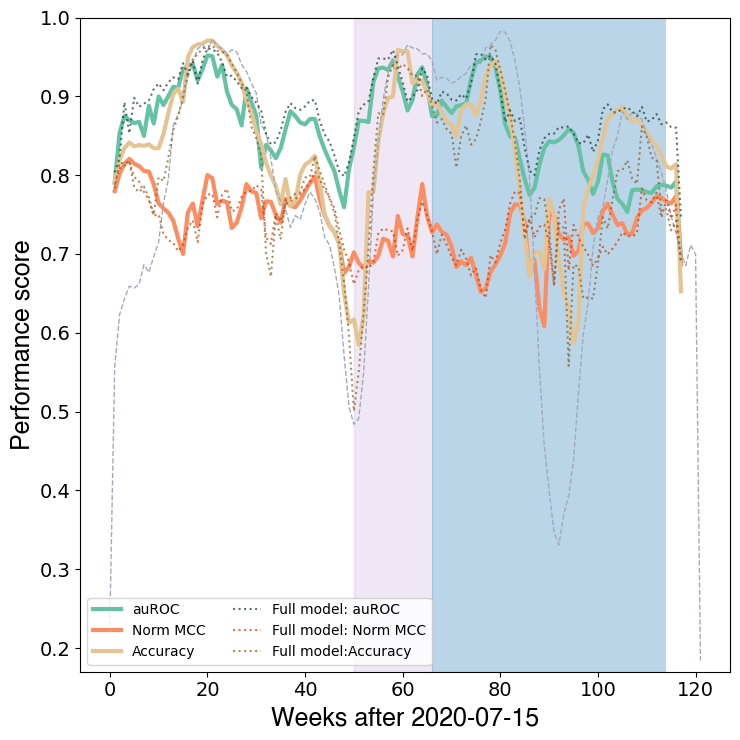

In [118]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5), sharey = 'all')

# Plot data on the same plot
axs.plot(weeks_to_predict, ROC_by_week_full_exact_unimportant, label='auROC', linewidth = 3, color = palette[0])
axs.plot(weeks_to_predict, norm_MCC_by_week_full_exact_unimportant, label='Norm MCC', linewidth = 3, color = palette[1])
axs.plot(weeks_to_predict, accuracy_by_week_full_exact_unimportant, label='Accuracy', linewidth = 3, color = palette[5])
axs.plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

axs.plot(weeks_to_predict, ROC_by_week_full_exact, label='Full model: auROC', linewidth = 1.5, color = '#173A2F', linestyle = ':', alpha = 0.7)
axs.plot(weeks_to_predict, norm_MCC_by_week_full_exact, label='Full model: Norm MCC', linewidth = 1.5, color = '#C83C04', linestyle = ':', alpha = 0.7)
axs.plot(weeks_to_predict, accuracy_by_week_full_exact, label='Full model:Accuracy', linewidth = 1.5, color = '#835C20', linestyle = ':', alpha = 0.7)

# Add labels and legend
axs.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

axs.set_ylabel('Performance score',**hfont,  fontsize = 18)
axs.tick_params(axis='both', which='major', labelsize=14)

axs.set_ylim(0.17,1)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs.legend(ncol = 2, loc='lower left')

polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
axs.add_patch(polygon_delta)
polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
axs.add_patch(polygon_omricon)

plt.tight_layout()
axs.legend(ncol = 2, loc='lower left')